<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Data Visualization</h1>
        <h2>Mapping</h2>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.rcParams["figure.figsize"] = (11,8)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import json

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -p numpy,matplotlib,pandas

Wed Sep 25 2019 

CPython 3.7.3
IPython 6.2.1

numpy 1.16.2
matplotlib 3.1.0
pandas 0.24.2

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Manhattan

We are going to use some geographical boundary information for the borough of Manhattan. For simplicity I've extracted the necessary data from the official shapefiles https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm. In this format the data can be easily loaded:

In [3]:
manhattan = json.loads(open("data/Manhattan.json", "rt").readline())

points = np.array(manhattan["points"])
parts = manhattan["parts"]

The data (similarly to shapefiles) is composed of a list of 2D points:

In [4]:
points

array([[-74.01092841,  40.68449147],
       [-74.0119326 ,  40.68388775],
       [-74.01217597,  40.68409519],
       ...,
       [-73.90682823,  40.87663155],
       [-73.90682004,  40.87658553],
       [-73.906651  ,  40.8757525 ]])

And indicators of which points belong to which line.

In [5]:
parts

[0,
 12,
 17,
 22,
 27,
 75,
 81,
 362,
 369,
 377,
 388,
 393,
 399,
 429,
 440,
 447,
 455,
 463,
 474,
 483,
 488,
 493,
 501,
 534,
 542,
 560,
 728,
 758,
 1004,
 6091,
 6104,
 6332,
 6332,
 6332]

This means that the first line is made up of points in position $[0:12)$, the second line of the points $[12:17)$, etc. We can now use this data to easily get a quick map of Manhattan. I've purposefully let matplotlib set the color for each individual line so that we can easily see the different parts of the figure

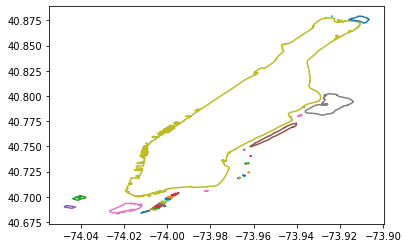

In [6]:
for i in range(len(parts)-1):
	plt.plot(points.T[0][parts[i]:parts[i+1]], points.T[1][parts[i]:parts[i+1]])

Let's add some points stored in a csv file of x, y coordinates

In [7]:
tweets = pd.read_csv('data/tweets.csv')

These are coordinates of real people tweeting with GPS locations enabled on a specific day:

In [8]:
tweets.head()

,X,Y
0,-73.997017,40.762337
1,-73.968542,40.780709
2,-73.985962,40.760342
3,-73.952610,40.810797
4,-73.968542,40.780709


We can now easily plot these points along side the geographical boundaries

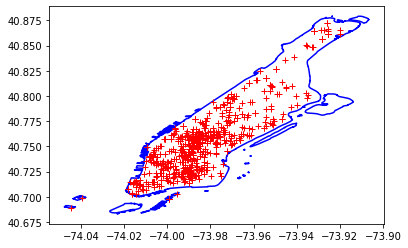

In [9]:
for i in range(len(parts)-1):
	plt.plot(points.T[0][parts[i]:parts[i+1]], points.T[1][parts[i]:parts[i+1]], 'b-')

plt.plot(tweets['X'], tweets['Y'], 'r+')

# Population matrix

Another common format for data is what is known as "raster" file. These are essentially matricies of numbers along with some metadata. Let's take a look at the US population in 2015 according to Columbia's Gridded Population of the World project https://sedac.ciesin.columbia.edu/data/collection/gpw-v4

In [10]:
data = np.loadtxt('data/US_pop.mat')

As you can see this is just a matrix of numbers. nan's are used to denote missing data

In [11]:
data.shape

(119, 246)

In [12]:
data[50,:]

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan, 1.43647803e+03,
       9.37134521e+02, 7.71265198e+02, 7.78246277e+02, 7.79848511e+02,
       3.08748901e+03, 2.14585605e+04, 4.40342695e+04, 3.14356094e+04,
       4.37279590e+03, 1.89785803e+03, 6.52430420e+03, 1.37475195e+03,
       1.79528894e+03, 1.61386096e+03, 1.17168201e+03, 1.01398602e+03,
       9.70716187e+02, 2.07381699e+02, 1.24349003e+01, 6.72574186e+00,
       2.57071710e+00, 1.25912104e+01, 1.28034401e+01, 1.30428400e+01,
       2.85179405e+01, 2.97565594e+01, 2.97565594e+01, 5.72180710e+01,
       1.06223701e+02, 1.02709297e+02, 9.62921829e+01, 1.12264000e+02,
       1.12264000e+02, 1.12264000e+02, 1.12264000e+02, 1.12264000e+02,
       1.12264000e+02, 1.18276497e+02, 1.45015793e+02, 1.45103897e+02,
       1.45133194e+02, 1.45294296e+02, 1.45463104e+02, 1.90916702e+02,
      

We can get a quick and dirty plot using imshow

In [13]:
data[data>0].min()

0.4878464937210083

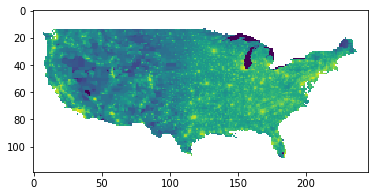

In [14]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(data+1))

In addition to this data, we also need the coordinates of the lower left hand corner and the cell size

In [15]:
xllcorner = -126.5
yllcorner = 22.75
cellsize = 0.25

Using this metadata we can now convert between raw lat/lon and matrix coordinates

In [16]:
def map_points(xllcorner, yllcorner, cellsize, nrows, x, y):
    x = int((x-xllcorner)/cellsize)
    y = (nrows-1)-int((y-yllcorner)/cellsize)

    return x, y

Which is useful when we want to add point or lines to the plot

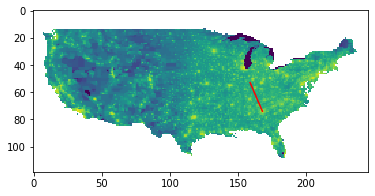

In [17]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(data+1))

x1, y1 = map_points(xllcorner, yllcorner, cellsize, data.shape[0], -86.523435, 39.163355, )
x2, y2 = map_points(xllcorner, yllcorner, cellsize, data.shape[0], -84.404820, 33.761926, )

ax.plot([x1, x2], [y1, y2], 'r-')

Add all the state boundaries https://www.usgs.gov/products/data-and-tools/gis-data in the same slightly massaged format as the Manhattan data above

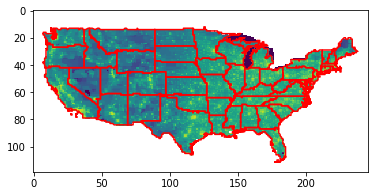

In [18]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(data+1))

shapes = json.loads(open("data/48states.json", "rt").readline())

pos = None
count = 0

for shape in shapes:
        points = np.array(shape["points"])
        parts = shape["parts"]

        for i in range(len(parts)-1):
            positions = []

            for j in range(parts[i+1]-parts[i]):
                x_orig = points.T[0][parts[i]+j]
                y_orig = points.T[1][parts[i]+j]
                x, y = map_points(xllcorner, yllcorner, cellsize, data.shape[0], x_orig, y_orig)
                positions.append([x, y])
            
            positions = np.array(positions)

            ax.plot(positions.T[0], positions.T[1], 'r-')

# Data aggregation

The main advantage of being able to easily disply matricies of data is that you can aggregate geographical data into a matrix to plotting.

Define the constants needed to convert between matrix coordinates to lat/lon

In [19]:
xllcorner = -74.0477296269704
yllcorner = 40.68291694544512
xurcorner = -73.9066509953948
yurcorner = 40.87903804730722
cellsize = 0.001

Build a matrix that counts how many tweets occurred in each cell of Manhattan

In [20]:
ncols = int((xurcorner-xllcorner)/cellsize)
nrows = int((yurcorner-yllcorner)/cellsize)

data = np.zeros((nrows, ncols), dtype='int')

for tweet_id in range(tweets.shape[0]):
    try:
        coordinates = tweets.iloc[tweet_id]
                    
        coord_x, coord_y = map_points(xllcorner, yllcorner, cellsize, nrows, coordinates[0], coordinates[1])
        data[coord_y, coord_x] += 1
    except:
        pass

Plot the resulting matrix. It should be noted that in practice there is no difference between this matrix and the population matrix we used above

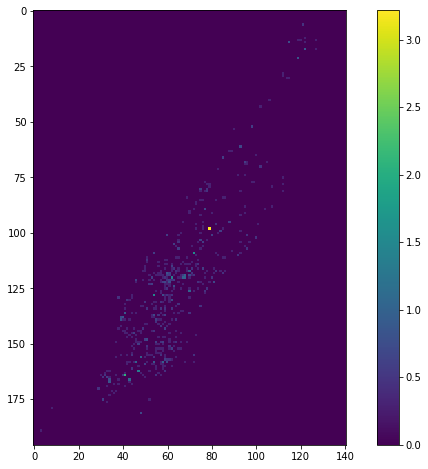

In [21]:
plt.imshow(np.log10(data+1))
plt.colorbar()
plt.gcf().set_size_inches(11, 8)

Naturally we can also add the boundary information. Reload the data

In [22]:
manhattan = json.loads(open("data/Manhattan.json", "rt").readline())

points = np.array(manhattan["points"])
parts = manhattan["parts"]

Generate the joint plot. Here we use the **extent** parameter to redifine the x,y axis coordinates to be lat and lon. 

(-74.0477296269704, -73.9066509953948, 40.68291694544512, 40.87903804730722)

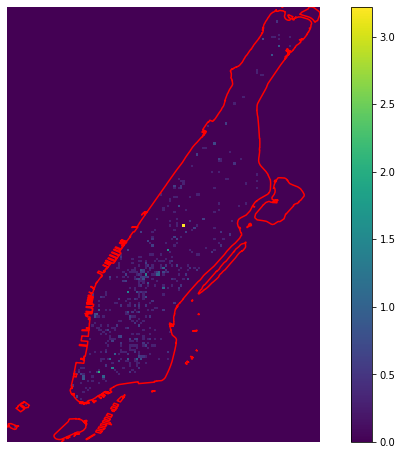

In [23]:
plt.imshow(np.log10(data+1), extent=(xllcorner, xurcorner, yllcorner, yurcorner))

for i in range(len(parts)-1):
	plt.plot(points.T[0][parts[i]:parts[i+1]], points.T[1][parts[i]:parts[i+1]], 'r-')

plt.colorbar()
plt.gcf().set_size_inches(11, 8)
plt.axis('off')

# Basemap

**Basemap** is a **matplotlib** add on package that is built specifically to easily handle the mapping of geographical information. Plotting a minimalistic map of the world takes just a couple of lines.

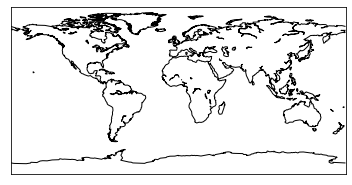

In [24]:
 map = Basemap()
 map.drawcoastlines()

We can also use different projections and select only part of the map

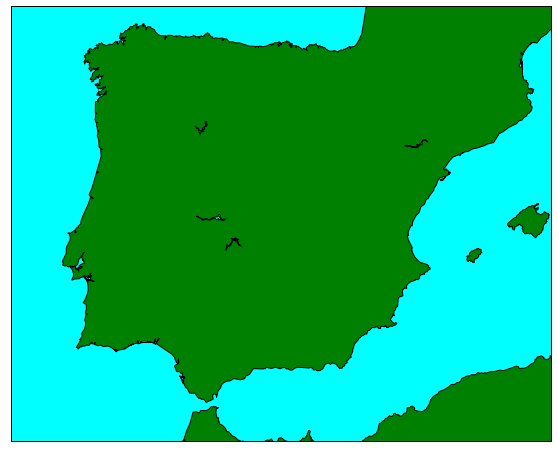

In [25]:
map = Basemap(llcrnrlon=-10.5,llcrnrlat=35,urcrnrlon=4.,urcrnrlat=44.,
             resolution='i', projection='tmerc', lat_0 = 39.5, lon_0 = -3.25)

map.drawmapboundary(fill_color='cyan')
map.fillcontinents(color='green',lake_color='aqua')
map.drawcoastlines()
plt.gcf().set_size_inches(11, 8)

And draw great circles connecting points on the map. This and other examples can be found in the official Basemap documentation https://matplotlib.org/basemap/users/examples.html

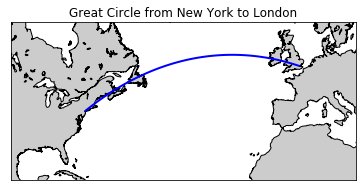

In [26]:
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
# draw great circle route between NY and London
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
m.drawcoastlines()
m.fillcontinents()
ax.set_title('Great Circle from New York to London');

Easily add paralles and meridians

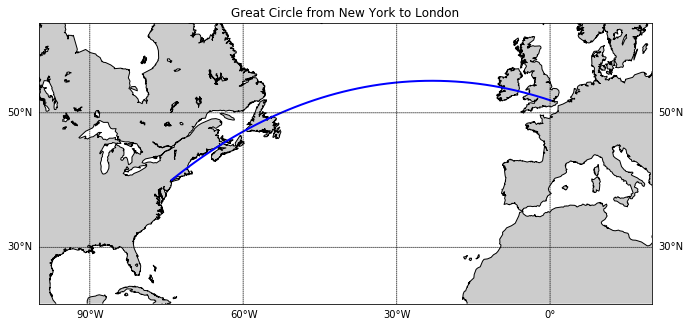

In [27]:
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)

# nylat, nylon are lat/lon of New York
nylat = 40.78
nylon = -73.98
lonlat = 51.53
lonlon = 0.08

# draw great circle route between NY and London
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
plt.gca().set_title('Great Circle from New York to London')
plt.gcf().set_size_inches(11, 8)

Or even plot it on the globe

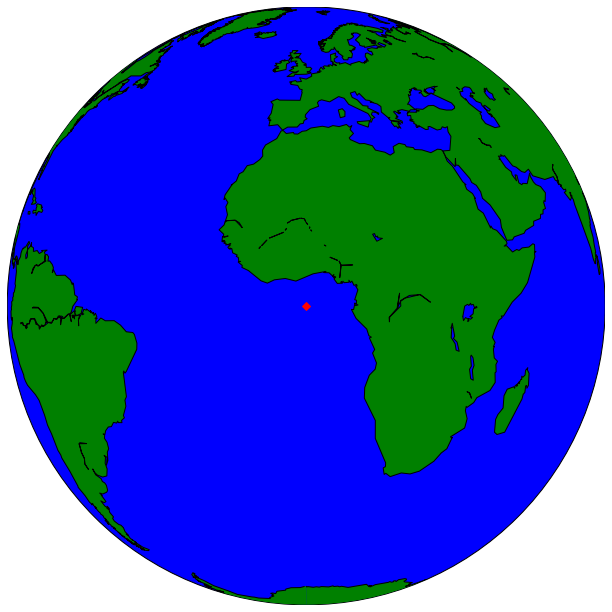

In [28]:
m = Basemap(projection='ortho', lat_0=0, lon_0=0)

m.drawmapboundary(fill_color='blue')
m.fillcontinents(color='green',lake_color='blue')
m.drawcoastlines()

x, y = m(0, 0)

m.plot(x, y, marker='D',color='red')
plt.gcf().set_size_inches(11, 11)

including the great circles

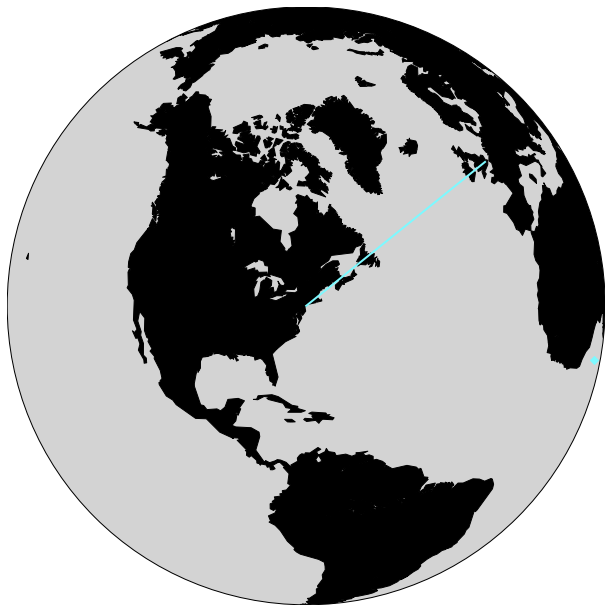

In [29]:
m = Basemap(projection='ortho', lat_0=nylat, lon_0=nylon)

m.drawmapboundary(fill_color='lightgray')
m.fillcontinents(color='black',lake_color='lightgray')
m.drawcoastlines()

x, y = m(0, 0)

m.plot(x, y, marker='D',color='#7DF9FF')
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='#7DF9FF')
plt.gcf().set_size_inches(11, 11)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>